# Safety Driving Detection using CNN

In [ ]:
import sys
!{sys.executable} -m pip install wget
!{sys.executable} -m pip install pytest-shutil

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=c7001b7afef2c5eae22b0cb418671064fefddc32fdb284811a5f88aaad8dd295
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Import Libraries

In [ ]:
# Libraries
import pandas as pd
import numpy as np
np.random.seed(42)
import os
import os.path
from os import path
import shutil
from shutil import unpack_archive
pd.set_option("display.max_columns", 101)

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model


from sklearn.metrics import classification_report, confusion_matrix

## Dataset

In [ ]:
# Run this cell block to download and extract image data
!wget 'https://hr-projects-assets-prod.s3.amazonaws.com/1iaanii247i/8c7bc0c59ee6bcdb3646a1997606a9d0/test.zip'
!wget 'https://hr-projects-assets-prod.s3.amazonaws.com/1iaanii247i/ffe8804da24b94ee410a8730ba297dfc/train_0.zip'
!wget 'https://hr-projects-assets-prod.s3.amazonaws.com/1iaanii247i/5460fcc87e2d7f7e19c17f719e0df00a/train_1.zip'

print('Extracting Train Dataset : Label 1')
unpack_archive('train_1.zip', '')

print('Extracting Train Dataset : Label 0')
unpack_archive('train_0.zip', '')

print('Extracting Test Dataset')
unpack_archive('test.zip', '')

print('Dataset Extracted')


os.remove('train_1.zip')
os.remove('train_0.zip')
os.remove('test.zip')
print('Extra Files Removed')

--2022-06-21 03:34:24--  https://hr-projects-assets-prod.s3.amazonaws.com/1iaanii247i/8c7bc0c59ee6bcdb3646a1997606a9d0/test.zip
Resolving hr-projects-assets-prod.s3.amazonaws.com (hr-projects-assets-prod.s3.amazonaws.com)... 52.216.166.19
Connecting to hr-projects-assets-prod.s3.amazonaws.com (hr-projects-assets-prod.s3.amazonaws.com)|52.216.166.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58948996 (56M) [application/zip]
Saving to: ‘test.zip’

test.zip            100%[===================>]  56.22M  98.9MB/s    in 0.6s    

2022-06-21 03:34:25 (98.9 MB/s) - ‘test.zip’ saved [58948996/58948996]

--2022-06-21 03:34:25--  https://hr-projects-assets-prod.s3.amazonaws.com/1iaanii247i/ffe8804da24b94ee410a8730ba297dfc/train_0.zip
Resolving hr-projects-assets-prod.s3.amazonaws.com (hr-projects-assets-prod.s3.amazonaws.com)... 52.216.171.131
Connecting to hr-projects-assets-prod.s3.amazonaws.com (hr-projects-assets-prod.s3.amazonaws.com)|52.216.171.131|:443... co

## Data Description

Column | Description
:---|:---
`file` | Image name
`label` | Target Label (1/0)

In [ ]:
# The train label dataset is already loaded below
data = pd.read_csv("train_labels.csv")

In [ ]:
data.head()

,file,label
0,img_44733.jpg,1.0
1,img_72999.jpg,1.0
2,img_25094.jpg,1.0
3,img_69092.jpg,1.0
4,img_92629.jpg,1.0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4015 entries, 0 to 4014
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   file    4015 non-null   object 
 1   label   4015 non-null   float64
dtypes: float64(1), object(1)
memory usage: 62.9+ KB


In [ ]:
data['label'].value_counts()

0.0    2026
1.0    1989
Name: label, dtype: int64

In [ ]:
# train directory and list number of files
for dirpath, dirnames, filenames in os.walk("train"):
  print(f"There ara {len(dirnames)} directories and {len(filenames)} images in '{dirpath}' .")

There ara 2 directories and 0 images in 'train' .
There ara 0 directories and 1989 images in 'train/1' .
There ara 0 directories and 2026 images in 'train/0' .


In [ ]:
# test directory and list number of files
for dirpath, dirnames, filenames in os.walk("test"):
  print(f"There ara {len(dirnames)} directories and {len(filenames)} images in '{dirpath}' .")

There ara 0 directories and 1401 images in 'test' .


## View Image

In [ ]:
# View an image

def view_random_image(target_dir, target_class):
    # Setup target directory
    target_folder = target_dir + target_class

    # Get a random image path
    random_image = random.sample(os.listdir(target_folder), 1)

    # Read in the image and plot i
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off")

    print(f"Image shape {img.shape}")

    return img

Image shape (480, 640, 3)


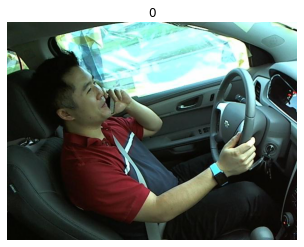

In [ ]:
# View a random image from the training dataset label 0
img = view_random_image(target_dir = "train/",
                        target_class = "0")

Image shape (480, 640, 3)


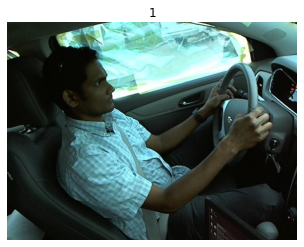

In [ ]:
# View a random image from the training dataset label 1
img = view_random_image(target_dir = "train/",
                        target_class = "1")

## Validation File

In [ ]:
#create validataion directory
!mkdir validation
os.mkdir('validation/0')
os.mkdir('validation/1')

#validation size 20%
len_label_0 = round((len(data[data['label'] == 0.0])*0.2))
len_label_1 = round((len(data[data['label'] == 1.0])*0.2))

#list validation file name
list_0 = data[data['label'] == 0.0][:len_label_0]['file'].to_list()
list_1 = data[data['label'] == 1.0][:len_label_1]['file'].to_list()

#Move 20% image from train file to validation file
for fname in list_0:
  shutil.move("train/0/"+fname, "validation/0") 

for fname in list_1:
  shutil.move("train/1/"+fname, "validation/1") 

In [ ]:
# train directory and list number of files
for dirpath, dirnames, filenames in os.walk("train"):
  print(f"There ara {len(dirnames)} directories and {len(filenames)} images in '{dirpath}' .")

print("")

# validation directory and list number of files
for dirpath, dirnames, filenames in os.walk("validation"):
  print(f"There ara {len(dirnames)} directories and {len(filenames)} images in '{dirpath}' .")

There ara 2 directories and 0 images in 'train' .
There ara 0 directories and 1591 images in 'train/1' .
There ara 0 directories and 1621 images in 'train/0' .

There ara 2 directories and 0 images in 'validation' .
There ara 0 directories and 398 images in 'validation/1' .
There ara 0 directories and 405 images in 'validation/0' .


## Machine Learning Model

In [ ]:
# Download the pre-trained weights.
!wget --no-check-certificate \https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \-O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2022-06-21 03:34:30--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.2.112, 172.253.62.128, 142.250.73.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.2.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   359MB/s    in 0.2s    

2022-06-21 03:34:30 (359 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [ ]:
# Set the weights file you downloaded into a variable
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model = InceptionV3(input_shape = (224, 224, 3), 
                                include_top = False,
                                weights = None)

# Load the pre-trained weights you downloaded.
pre_trained_model.load_weights(local_weights_file)

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
  layer.trainable = False

pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [ ]:
# Choose `mixed_7` as the last layer of your base model
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 12, 12, 768)


In [ ]:
#set the seed
tf.random.set_seed(10)

# Preprocess data
train_datagen = train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 20,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale = 1./255)

# Setup the train and test directories
train_dir  = "train/"
validation_dir = "validation/"

# Import data  from directory and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size = 32,
                                               target_size = (224,224),
                                               class_mode = "binary",
                                               seed = 10)
validation_data = test_datagen.flow_from_directory(validation_dir,
                                             batch_size = 32, # number of images to process at a time 
                                             target_size = (224,224), # convert all images to be 224 x 224
                                             class_mode = "binary", 
                                             seed = 10)


# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)


# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)

# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)

# Add a final sigmoid layer for classification
x = layers.Dense (1, activation='sigmoid')(x)

# Append the dense network to the base model
model = Model(pre_trained_model.input, x)

# Compile the model
model.compile(loss="binary_crossentropy",
                optimizer = RMSprop(learning_rate=0.0001),
                metrics = ["accuracy"])

#fit the model
history = model.fit(train_data,
                        epochs=20,
                        steps_per_epoch = len(train_data),
                        validation_data = validation_data,
                        validation_steps = len(validation_data))

Found 3212 images belonging to 2 classes.
Found 803 images belonging to 2 classes.
Epoch 1/20
101/101 [==============================] - 67s 518ms/step - loss: 0.7003 - accuracy: 0.6887 - val_loss: 0.4492 - val_accuracy: 0.8082
Epoch 2/20
101/101 [==============================] - 52s 513ms/step - loss: 0.4149 - accuracy: 0.8166 - val_loss: 0.5332 - val_accuracy: 0.7422
Epoch 3/20
101/101 [==============================] - 51s 503ms/step - loss: 0.3190 - accuracy: 0.8677 - val_loss: 0.4774 - val_accuracy: 0.7771
Epoch 4/20
101/101 [==============================] - 51s 500ms/step - loss: 0.2824 - accuracy: 0.8826 - val_loss: 0.3052 - val_accuracy: 0.8742
Epoch 5/20
101/101 [==============================] - 51s 502ms/step - loss: 0.2476 - accuracy: 0.9026 - val_loss: 0.3799 - val_accuracy: 0.8120
Epoch 6/20
101/101 [==============================] - 52s 512ms/step - loss: 0.2166 - accuracy: 0.9166 - val_loss: 0.8505 - val_accuracy: 0.7173
Epoch 7/20
101/101 [===========================

### Model Evaluation

In [ ]:
# Evaluate on the test data
model.evaluate(validation_data)

26/26 [==============================] - 5s 171ms/step - loss: 0.2815 - accuracy: 0.9116


[0.28153228759765625, 0.9115815758705139]

In [ ]:
# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  #plot loss
  plt.plot(epochs, loss, label = "training_loss")
  plt.plot(epochs, val_loss, label = "val_loss")
  plt.title('Loss')
  plt.xlabel('epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label = "training_accuracy")
  plt.plot(epochs, val_accuracy, label = "val_accuracy")
  plt.title('Accuracy')
  plt.xlabel('epochs')
  plt.legend();

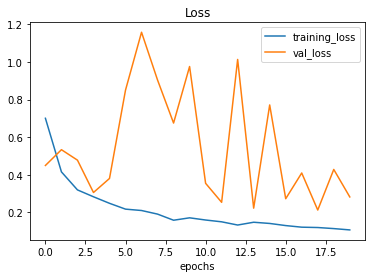

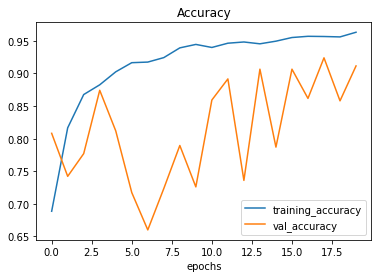

In [ ]:
# Check out the loss curves of model_4

plot_loss_curves(history)

In [ ]:
import pathlib
import numpy as np
#class name data
train_dir = pathlib.Path("train/") # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in train_dir.glob('*')]))
class_names

array(['0', '1'], dtype='<U1')

In [ ]:
pred_label = [] #prediction label list
img_filename = [] #validation image name list
true_label = [] #true validation label list
list_name = [list_0,list_1] #image validataion list
val_dir = ['validation/0/', 'validation/1/'] #validation class diretory

#predict the validation image and collect the prediction label
for i in [0,1]:
  for image in list_name[i]:
    img = tf.io.read_file(val_dir[i]+image)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, size = [224, 224])
    img = img/255.
    pred = model.predict(tf.expand_dims(img, axis=0))
    pred_class = class_names[int(tf.round(pred)[0][0])]
    pred_label.append(pred_class)
    img_filename.append(image)
    true_label.append(i)

#Create image name, true label, and prediction dataframe 
frame = pd.DataFrame(img_filename, columns = ['Image_file'])
frame['true_label'] = true_label
frame['pred_label'] = pred_label
frame.true_label = frame.true_label.astype(str)
frame

,Image_file,true_label,pred_label
0,img_16856.jpg,0,1
1,img_8410.jpg,0,1
2,img_15559.jpg,0,0
3,img_4562.jpg,0,0
4,img_11478.jpg,0,0
...,...,...,...
798,img_44644.jpg,1,1
799,img_37570.jpg,1,1
800,img_85624.jpg,1,1
801,img_23631.jpg,1,1


In [ ]:
#classification report on model peformance
print(classification_report(frame['true_label'], frame['pred_label']))

              precision    recall  f1-score   support

           0       0.97      0.86      0.91       405
           1       0.87      0.98      0.92       398

    accuracy                           0.92       803
   macro avg       0.92      0.92      0.92       803
weighted avg       0.92      0.92      0.92       803



In [ ]:
#confusion matrix
cm = confusion_matrix(frame['true_label'], frame['pred_label'])
cm

array([[348,  57],
       [  9, 389]])

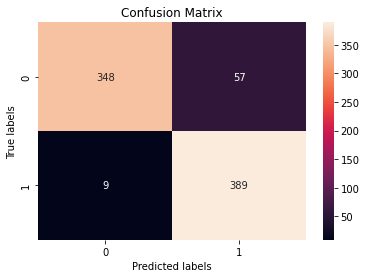

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt     

#create confution matrix plot
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 

## Predict Test Image

In [ ]:
# test directory
test_filename = [] #test file name list
for _, _, filenames in os.walk("test"):
  test_filename.append(filenames)

#convert the test file name to list type
test_filename = np.squeeze(test_filename).tolist()

#remove unnecessary file
test_filename.remove('.DS_Store')

In [ ]:
pred_test_label = [] #prediction test label list
img_test_filename = [] #test image name list


#predict the test image and collect the prediction label
for image in test_filename:
  img = tf.io.read_file('test/'+image)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.resize(img, size = [224, 224])
  img = img/255.
  pred = model.predict(tf.expand_dims(img, axis=0))
  pred_class = class_names[int(tf.round(pred)[0][0])]
  pred_test_label.append(pred_class)
  img_test_filename.append(image)

#Create image name,  prediction dataframe 
frame = pd.DataFrame(img_test_filename, columns = ['File'])
frame['Label'] = pred_test_label
frame

,File,Label
0,img_64030.jpg,1
1,img_60142.jpg,0
2,img_11658.jpg,1
3,img_49198.jpg,0
4,img_12773.jpg,0
...,...,...
1395,img_23844.jpg,0
1396,img_38915.jpg,0
1397,img_42917.jpg,0
1398,img_16717.jpg,0


In [ ]:
#sort value on File name
submission_df = frame.sort_values('File', ascending=True).reset_index()
submission_df

,index,File,Label
0,461,img_100337.jpg,1
1,917,img_10039.jpg,0
2,642,img_10053.jpg,0
3,142,img_10092.jpg,1
4,236,img_10096.jpg,0
...,...,...,...
1395,11,img_9967.jpg,1
1396,880,img_99696.jpg,1
1397,984,img_99779.jpg,1
1398,1197,img_99846.jpg,1
